<a href="https://colab.research.google.com/github/cafalchio/place_cells_analysis/blob/main/Mark0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reading data format Intan .dat

In [3]:
import glob, os
from tqdm.notebook import tqdm
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import struct
from resource import getrusage, RUSAGE_SELF
import gc
gc.enable()

# load data
sys.path.append("/content/drive/MyDrive/aHuman_data_Mark/load_intan_rhd_format/")
from load_intan_rhd_format import *

import scipy

## **Read metadata from recording**

In [4]:
metadata = read_data('/content/drive/MyDrive/aHuman_data_Mark/human_151126_135612/info.rhd')


Reading Intan Technologies RHD2000 Data File, Version 1.4

n signal groups 7
Found 110 amplifier channels.
Found 6 auxiliary input channels.
Found 2 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

Header file contains no data.  Amplifiers were sampled at 25.00 kS/s.
Done!  Elapsed time: 0.0 seconds


In [58]:
class Recording:
    '''class that reads data from a intan recording'''
    def __init__(self, path_to_data):
        # self.path_to_data = path_to_data
        # self.path = os.chdir(path_to_data)
        self.info = glob.glob(path_to_data+'/*.rhd')[0]
        print(self.info)
        self.header = read_data(glob.glob(path_to_data+'/info.rhd')[0])
        self.time = glob.glob(path_to_data+'/time.dat')[0]
        self.data_files = glob.glob(path_to_data+'/amp*.dat')
        self.aux_files = glob.glob(path_to_data+'/aux*.dat')
        self.board_files = glob.glob(path_to_data+'/board*.dat')
        self.vdd_files = glob.glob(path_to_data+'/vdd*.dat')
        self.n_samples, self.timestamp = self.read_timestamp(f_rate = 25000)
        self.data = np.array([], np.int16)

    def read_timestamp(self, f_rate = 25000):
        '''Function that reads timestamp from Intan recording'''
        size = os.path.getsize(self.time)
        num_samples = size/4
        n_samples = num_samples
        timestamp = np.fromfile(self.time, dtype=np.int32)
        timestamp = timestamp/f_rate
        print(f'Reading {len(timestamp)/(60*25000):.2f} minutes of recording.')
        return int(n_samples), timestamp

    def read_channel(self, channel_idx):
        '''Function that reads a single recording channel'''
        channel_file = self.data_files[channel_idx]
        print(f"Reading: {self.data_files[channel_idx].split('/')[-1]}")
        size = os.path.getsize(channel_file)
        num_samples = size/(1 * 2)
        if num_samples != self.n_samples:
            print('Error reading file, missing samples!')
        data_ch = np.fromfile(channel_file, dtype=np.int16)
        self.data = data_ch * 0.195
        self.get_memory_use()
        return self.data

    def plot_raw_sample(self):
        ax = plt.figure(figsize=(20,6))
        ax = plt.plot(self.timestamp[100:1000], self.data[100:1000])
        ax = plt.ylabel('Voltage uV')
        ax = plt.xlabel('Time (s)')
        plt.show()
        plt.close()
    
    def get_memory_use(self):
        mem = getrusage(RUSAGE_SELF).ru_maxrss/1024000
        print(f'Memory use: {mem:.1f}Gb')
        mem = 0
    
    def load_channels(self):
        res = []
        for i, file in tqdm(enumerate(self.data_files[0:50])):
            if i%10 == 0 and i>0:
                self.get_memory_use()
            res.append(np.memmap(file, mode="r", dtype=np.int16) * 0.195)
        return res

In [59]:
recording1 = Recording('/content/drive/MyDrive/aHuman_data_Mark/human_151126_135612/')

/content/drive/MyDrive/aHuman_data_Mark/human_151126_135612/info.rhd

Reading Intan Technologies RHD2000 Data File, Version 1.4

n signal groups 7
Found 110 amplifier channels.
Found 6 auxiliary input channels.
Found 2 supply voltage channels.
Found 0 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

Header file contains no data.  Amplifiers were sampled at 25.00 kS/s.
Done!  Elapsed time: 0.0 seconds
Reading 46.15 minutes of recording.


In [60]:
recording1.read_channel(0)

Reading: amp-A-063.dat
Memory use: 22.9Gb


array([ 41.73 , 153.27 , 148.785, ...,   3.12 ,  -2.535,   5.85 ])

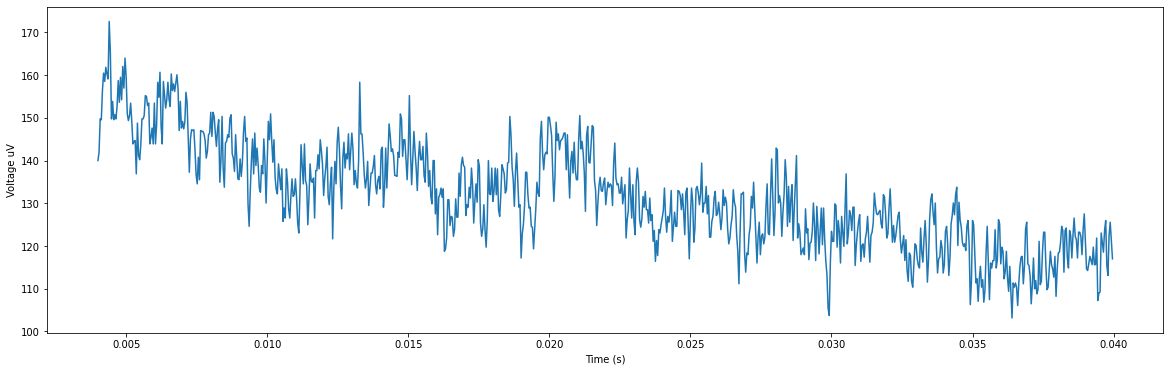

In [61]:
recording1.plot_raw_sample()